<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Capstone VI</font></h2>



<h1><font color="#00586D" size=5>Análisis de un problema de clasificación con deep learning</font></h1>
<br><br>

<div align="right">
<font color="#00586D" size=3>Fernando Rubio, Daniel González</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>

In [2]:
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.metrics as confusion_matrix
from sklearn.model_selection import train_test_split

**Nota**: en este notebook es esencial utilizar la GPU para entrenar nuestras redes.

---

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>


* [1. Introducción](#section1)
* [2. Dataset](#section2)
* [3. Preprocesamiento de datos](#section3)
* [4. Ejemplo](#section4)
* [5. Creación de un modelo desde cero](#section5)
* [6. Ajuste de hiperparámetros](#section6)
* [7. Modelos pre-entrenados](#section7)
* [8. Data augmentation](#section8)
* [9. Autokeras](#section9)

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section1"></a> 
## <font color="#00586D"> 1. Introducción</font>
<br>

El objetivo del Capstone es **simular un análisis completo de un problema de clasificación de imágenes usando Deep Learning**.

El análisis está compuesto de una serie de pasos que iremos viendo detenidamente uno por uno, que os puede servir de guía para seguir a la hora de resolver un problema con Deep Learning. Los **pasos** que vamos a seguir son los siguientes:

1. **Dataset**: Descarga y previsualización de los datos.
2. **Preprocesamiento de los datos**: prepararemos las imágenes para que puedan ser entrenadas.
3. **Modelo desde cero**: Creación de una red neuronal desde cero.
4. **Ajuste de hiperparámetros**: Mejora del modelo anterior mediante el ajuste de hiperparámetros.
5. **Modelos pre-entrenados (fine-tunning)**: Uso de técnicas de *Finetunning* sobre un modelo pre-entrenado.
6. **Data augmentation (Opcional)**: Uso de *data augmentation* en el dataset.
7. **Conclusión**: se deberá sacar unas conclusiones a partir de los resultados obtenidos, decidiendo cual de los modelos entrenados podríamos desplegar en producción para usarlo.

Los puntos a completar son del 3 al 7, en **cada punto se detalla exactamente qué se tiene que hacer**, es decir, habrá bloques de código en blanco y se detallará las arquitectura de las redes y la configuración de los entrenamientos, por lo que las redes a crear serán las indicadas en cada paso.

Al final de cada paso habrá que comentar los resultados obtendos en los entrenamientos, sacando **conclusiones de los experimentos** que vamos a llevar acabo, justificando y midiendo el rendimiento de los modelos obtenidos según las técnicas que utilicemos. La evaluación de los modelos se realizará en terminos de tasa de aciertos y la matriz de confusión de las clases.

_**Nota**: ejecuta el siguiente código para montar tu Drive y no perder los datos que vayamos a descargar. Además se hará un `cd` hacia el drive para guardar ahí todos los datos generados y descargados_

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/MyDrive/

/content/drive/MyDrive


<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section2"></a> 
## <font color="#00586D"> 2. Dataset</font>
<br>
El dataset utilizado está compuesto por imágenes de distintas razas de perro. El dataset contiene 12.891 imágenes con 74 razas, por lo tanto, el objetivo será crear y entrenar un módelo que clasifique la raza de un perro a partir de una imagen. Para descargar el dataset ejecuta la siguiente celda:

In [ ]:
"""!wget 'https://pruebasaluuclm-my.sharepoint.com/:u:/g/personal/fernando_rubio_uclm_es/ESpljekZA9dAgxsfc3qIDvEBMT76g8rPDOpMwgDwHe0BKw?download=1'
!mv 'ESpljekZA9dAgxsfc3qIDvEBMT76g8rPDOpMwgDwHe0BKw?download=1' dog-images.zip
#!unzip -q dog-images.zip #original - Hay archivos que desaparecen
!unzip -n dog-images.zip #modificación comentada en Slack - No desaparecen archivos"""

"!wget 'https://pruebasaluuclm-my.sharepoint.com/:u:/g/personal/fernando_rubio_uclm_es/ESpljekZA9dAgxsfc3qIDvEBMT76g8rPDOpMwgDwHe0BKw?download=1'\n!mv 'ESpljekZA9dAgxsfc3qIDvEBMT76g8rPDOpMwgDwHe0BKw?download=1' dog-images.zip\n#!unzip -q dog-images.zip #original - Hay archivos que desaparecen\n!unzip -n dog-images.zip #modificación comentada en Slack - No desaparecen archivos"

Se descargará un archivo `dog-images.zip` que se descomprimirá automáticamente creando la carpeta `dog-dataset` que contiene el dataset completo. La estructura de los ficheros descargados sera:

```
--> dog-images.zip
--> dog-dataset/
-->    test.csv
-->    train.csv
-->    valid.csv
-->    dog-images/
-->        Afghan_hound/
-->        African_hunting_dog/
-->        ...
```


En el interior de la carpeta `dog-dataset` se encuentrarn 3 ficheros *CSVs* y otra carpeta (`dog-images`):

* Carpeta `dog-images`: contiene todas las imágenes del dataset. Las imágenes están distribuidas por carpetas según las disintas razas (74 carpetas en total). El nombre de cada carpeta corresponde con la raza.
* `train.csv`: conjunto de datos para el entrenamiento, 8.992 imágenes. El fichero está en formato *CSV* y cada fila se corresponde con una imagen distinta. El *CSV* tiene 2 columnas, la columna *label* que corresponde a la clase (raza) y la columna *path* que correponde con la ruta donde está cada imagen en la carpeta `dog-images`.
* `valid.csv`: conjunto de datos para la validación, 1.894 imágenes. Mismo formato que `train.csv`.
* `test.csv`: conjunto de datos para el test, 2.005 imágenes. Mismo formato que `train.csv`.

A continuación se muestran varias imágenes del dataset.

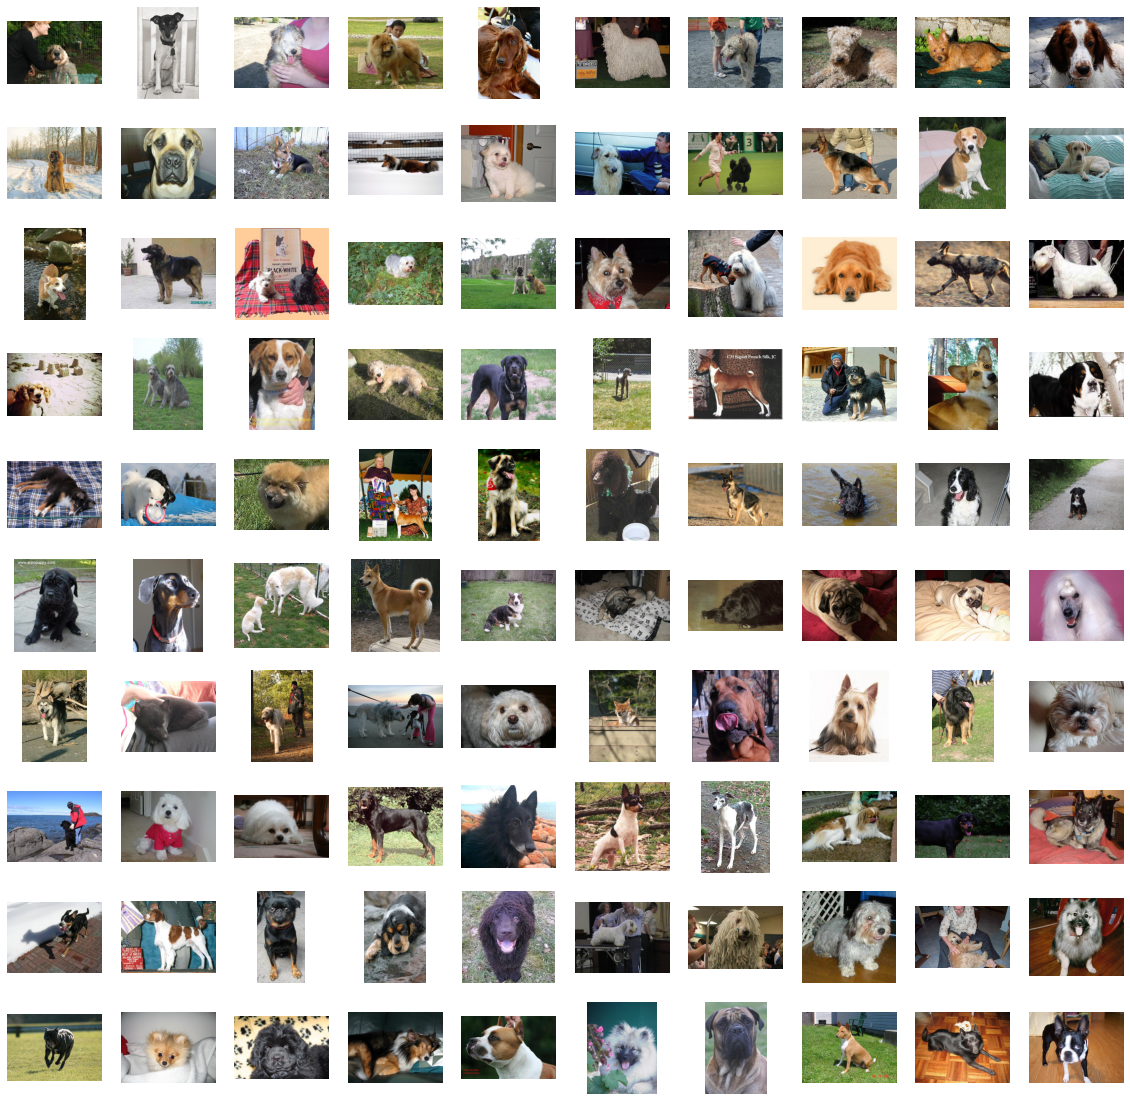

In [5]:
def show_images(img_paths):
    fig=plt.figure(figsize=(20, 20))
    index = np.random.randint(len(img_paths), size=100)
    for i in range(100):
        fig.add_subplot(10, 10, i+1)
        plt.axis('off')
        img = Image.open(img_paths[index[i]])
        plt.imshow(img)
    plt.show()
    
files = [f for f in glob.glob("dog-dataset/dog-images/**/*.jpg", recursive=True)]
show_images(files)

Podemos obserar las siguientes características que pueden complicar el problema:

- Las imágenes son de **diferentes tamaños**.
- Hay **diferentes objetos en las imágenes**.

Vamos a crear un lista (`classes`) con el nombre de las razas de los perros que serán las clases en las que clasificarán los modelos que creemos:

In [6]:
classes = [f.split('/')[-1] for f in glob.glob("dog-dataset/dog-images/**")]
classes

['beagle',
 'bluetick',
 'borzoi',
 'Norwegian_elkhound',
 'American_Staffordshire_terrier',
 'Irish_terrier',
 'Lakeland_terrier',
 'Sealyham_terrier',
 'cairn',
 'Dandie_Dinmont',
 'Scotch_terrier',
 'soft-coated_wheaten_terrier',
 'West_Highland_white_terrier',
 'golden_retriever',
 'Labrador_retriever',
 'Gordon_setter',
 'Brittany_spaniel',
 'clumber',
 'English_springer',
 'cocker_spaniel',
 'groenendael',
 'briard',
 'Old_English_sheepdog',
 'German_shepherd',
 'Greater_Swiss_Mountain_dog',
 'Bernese_mountain_dog',
 'bull_mastiff',
 'Tibetan_mastiff',
 'malamute',
 'pug',
 'chow',
 'keeshond',
 'Brabancon_griffon',
 'Pembroke',
 'Cardigan',
 'miniature_poodle',
 'Mexican_hairless',
 'toy_terrier',
 'bloodhound',
 'Scottish_deerhound',
 'Sussex_spaniel',
 'Irish_water_spaniel',
 'Doberman',
 'Samoyed',
 'otterhound',
 'Shetland_sheepdog',
 'French_bulldog',
 'Australian_terrier',
 'Great_Pyrenees',
 'Maltese_dog',
 'whippet',
 'Boston_bull',
 'Irish_setter',
 'Rottweiler',
 'schi

Vamos a mostrar una imagen aleatoria por cada clase:

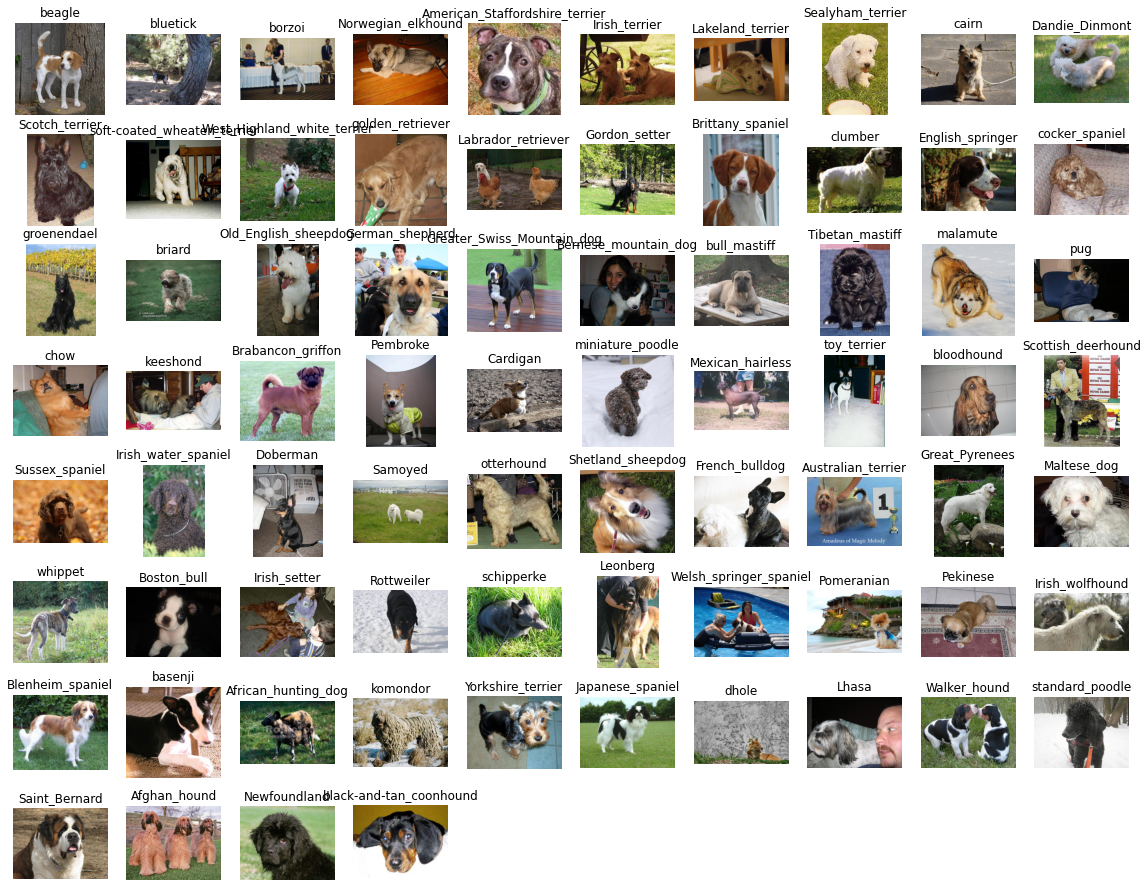

In [7]:
img_per_class = {}

for c in classes:
   files = [f for f in glob.glob(f"dog-dataset/dog-images/{c}/**.jpg")]
   index = np.random.randint(len(files))
   img_per_class[c] = files[index]

fig=plt.figure(figsize=(20, 20))
for i, (k, v) in enumerate(img_per_class.items()):
    fig.add_subplot(10, 10, i+1)
    plt.axis('off')
    img = Image.open(v)
    plt.title(k);
    plt.imshow(img)
plt.show()

Veamos si las clases están balanceadas:

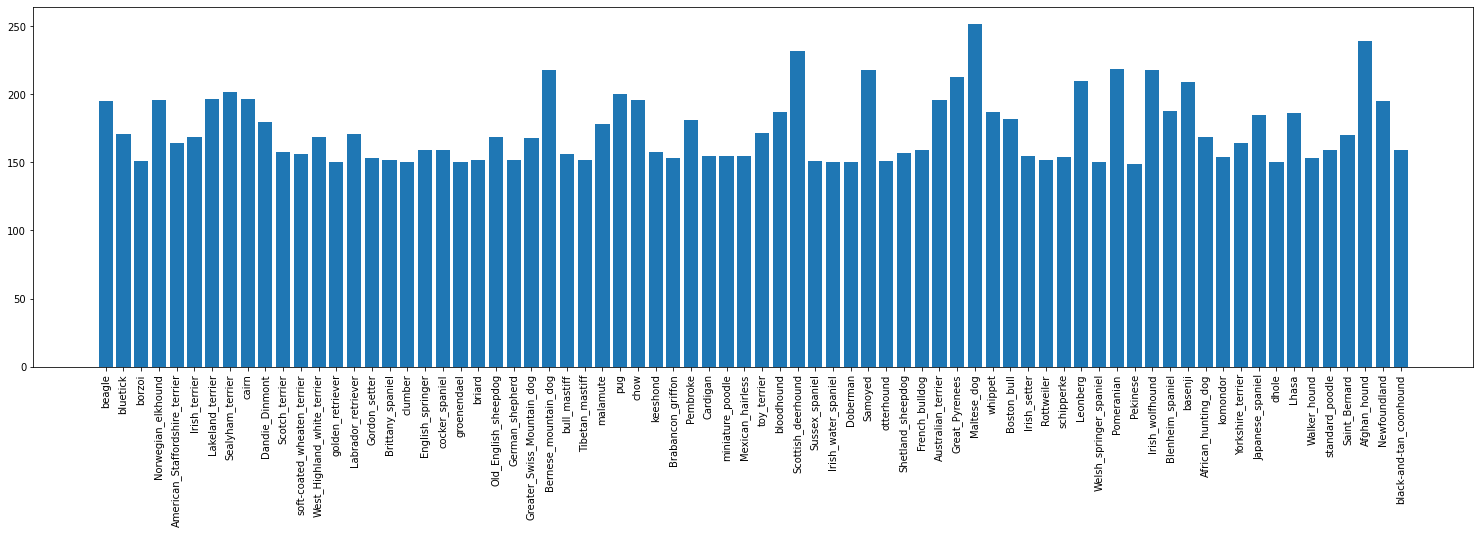

In [8]:
targets = [len([f for f in glob.glob(f"dog-dataset/dog-images/{c}/**.jpg")]) for c in classes]

fig = plt.figure(figsize=(20, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(classes,targets)
plt.xticks(rotation='vertical')
plt.show()

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section3"></a> 
## <font color="#00586D"> 3. Preprocesamiento de datos</font>
<br>


En esta sección vamos a cargar los datos creando los dataset para el conjunto de training, de validación y de test. En otras prácticas hemos visto como cargar con `tf.keras.utils.Sequence` y `tf.data.Dataset` batches de imágenes. En este caso, nos vamos a centrar en el segundo, ya que es más eficiente, sobre todo en Colab, como comentamos en la sección de Carga de datos masiva.

En este Capstone os vamos a dar una serie de funciones que permiten ejecutar los experimentos de forma más rápida para que no os tengáis que preocupar por la configuración de la base de datos.

In [9]:
def read_image(image_path, label):
    """
      Cargamos una imagen usando su ruta (path), la convertimos en tensor y la normalizamos
    """
    contents = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(contents, channels=3)
    img = tf.cast(img, tf.float64)
    img /= 255.0
    return img, label

def resize_image(img, label, target_size):
    """
      Redimensionamos una imagen
    """
    resized_img = tf.image.resize(img, target_size)
    return resized_img, label

def get_dataset(image_paths, image_labels, target_size, batch_size, prep_func=None):
    """
      - Generamos un objeto tf.data.Dataset para optimizar el entrenamiento desde los 
        paths de las imagenes
      - Aplicamos las funciones read_image y resize_image a las imagenes
      - Podemos usar una función prep_func si queremos hacer fine-tunning
    """
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    dataset = dataset.map(read_image)
    dataset = dataset.map(lambda x, y: resize_image(x, y, target_size))  

    if prep_func != None:
        dataset = dataset.map(lambda x, y: (x*255.0, y))
        dataset = dataset.map(lambda x, y: (prep_func(x), y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

Con estas funciones, podemos crear unos `tf.data.Dataset` que son óptimos a la hora de leer imágenes en memoria y ejecutar los batches y la forma de crearlos y ejecutarlos es la siguiente: 

```python
# definimos el img_size objetivo y el batch_size
img_size = (224,224,3)
batch_size = 32

# esta funcion obtiene la base de datos, e incluso podemos pasarle una preprocessing function
train_dataset = get_dataset(images_train_paths, labels_train, img_size[0:-1], batch_size)

# ya solo nos queda llamar a fit con la base de datos
model.fit(train_dataset, epochs=10)
```

Así es como deberemos llamar al método en celdas sucesivas cuando queramos entrenar nuestras redes.

Aunque tenemos los csv con los conjuntos de `train`, `valid` y `test`, vamos generar las particiones nosotros mismos para ver cómo se hace y para asegurarnos que lo hacemos de forma correcta.


In [10]:
num_to_label = {i: c for i, c in enumerate(classes)}
label_to_num = {c: i for i, c in enumerate(classes)}
image_paths = np.array([f for f in glob.glob("dog-dataset/dog-images/**/*.jpg", recursive=True)])
image_labels =  np.array([label_to_num[f.split('/')[-2]] for f in glob.glob("dog-dataset/dog-images/**/*.jpg", recursive=True)])

In [11]:
shuffler = np.random.permutation(len(image_paths))
image_paths = image_paths[shuffler]
image_labels = image_labels[shuffler]

# Train/valid/test split
x_train_valid, x_test, y_train_valid, y_test = train_test_split(image_paths, image_labels, test_size=0.1, random_state=1234, stratify=image_labels)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, random_state=5678, stratify=y_train_valid)

print("Train: ", x_train.shape)
print("Valid: ", x_valid.shape)
print("Test: ", x_test.shape)

del x_train_valid, y_train_valid

Train:  (9280,)
Valid:  (2321,)
Test:  (1290,)


Una vez tenemos listas las particiones, ya solo tenemos que crear los datasets con las funciones proporcionadas.

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section4"></a> 
## <font color="#00586D"> 4. Experimento ejemplo</font>
<br>

Aquí os mostramos un ejemplo de experimento y evaluación de un modelo. Podéis basaros en este para los modelos que tenéis que crear vosotros. Además de las gráficas de train y validación, hay una celda que muestra la matriz de confusión de la clase y que deberéis utillizar en los ejercicios.

### <font color="#00586D"> Arquitectura y configuración de la red</font>

La arquitectura de la red debe ser siguiente:
* Tamaño de entrada será `(100, 120, 3)`.
* Capa *Fully connected* con 1 neurona con activación *ReLU*.
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `categorical_crossentropy`
* Optimizador: `Adam`
* Learning rate: 0,001
* Epochs: 2
* Tamaño del batch: 128

In [ ]:
# Cargamos datos con las funciones de generación de dataset
img_size = (100,120,3)
train_dataset = get_dataset(x_train, y_train, img_size[:-1], 128)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], 128)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], 128)

In [ ]:
# Creamos nuestra red
model = tf.keras.Sequential([
  tf.keras.layers.Input(img_size),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="relu"),
  tf.keras.layers.Dense(len(classes), activation="softmax")
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 36000)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 36001     
                                                                 
 dense_7 (Dense)             (None, 74)                148       
                                                                 
Total params: 36,149
Trainable params: 36,149
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Configuramos entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Entrenamos
history = model.fit(train_dataset, epochs=2, validation_data=valid_dataset)

Epoch 1/2
73/73 [==============================] - 471s 7s/step - loss: 4.3081 - accuracy: 0.0176 - val_loss: 4.3024 - val_accuracy: 0.0198
Epoch 2/2
73/73 [==============================] - 38s 525ms/step - loss: 4.3020 - accuracy: 0.0195 - val_loss: 4.3011 - val_accuracy: 0.0198


In [ ]:
# Evaluamos con el conjunto de test
model.evaluate(test_dataset)

11/11 [==============================] - 3s 311ms/step - loss: 4.3010 - accuracy: 0.0194


[4.30095100402832, 0.01937984488904476]

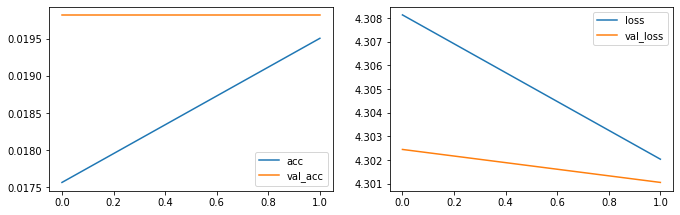

In [ ]:
# Visualizamos la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

plt.show()

11/11 [==============================] - 3s 306ms/step


<Axes: >

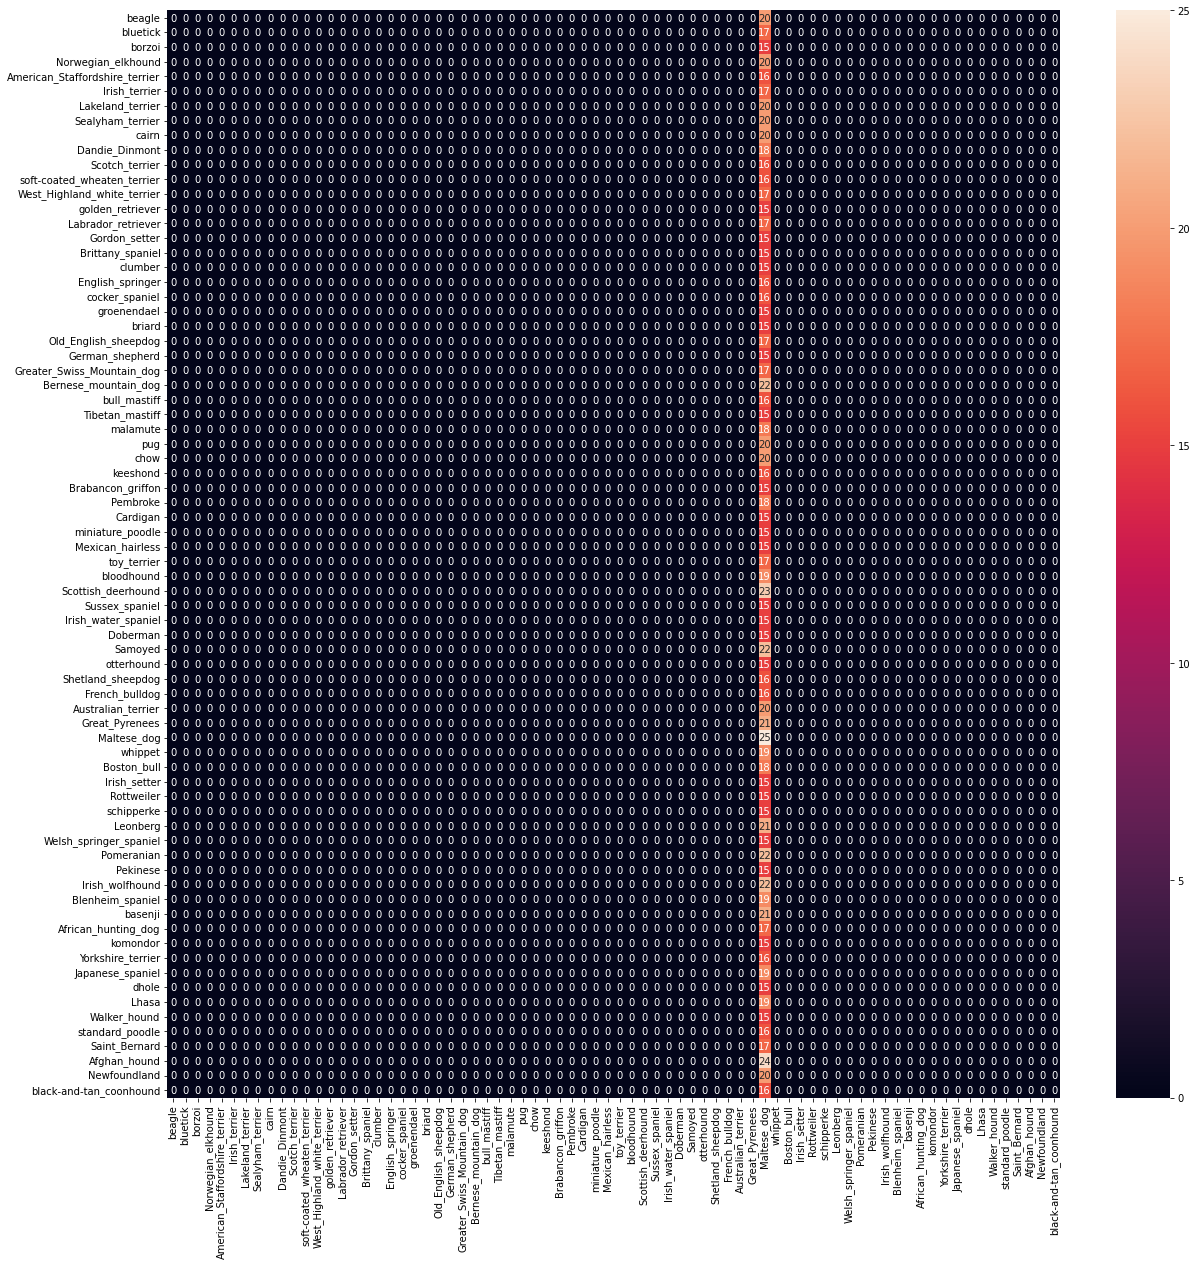

In [ ]:
# Visualizamos la matriz de confusion
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true= y_test
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)

df_cm=pd.DataFrame(confusion_matrix, index = [i for  i in classes], columns = [i for i in classes])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section5"></a> 
## <font color="#00586D"> 5. Creación de un modelo desde cero</font>
<br>


En esta sección se diseñará y entrenará una red convolucional siguiendo una estructura de tipo *VGG16* como las que vimos en clase. Una vez entrenada la red, tendrás que evaluar el resultado.

### <font color="#00586D"> Arquitectura y configuración de la red</font>

La arquitectura de la red debe ser siguiente:
* Tamaño de entrada será `(100, 120, 3)`.
* Capa convolucional con 32 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa convolucional con 64 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa *Fully connected* con 1024 neuronas con activación *ReLU*.
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `sparse_categorical_crossentropy`
* Optimizador: `Adam`
* Learning rate: 0,001
* Epochs: 10
* Tamaño del batch: 128

In [ ]:
# Cargamos datos con las funciones de generación de dataset
img_size = (100,120,3)
batch_size = 128

# esta funcion obtiene la base de datos, e incluso podemos pasarle una preprocessing function
train_dataset = get_dataset(x_train, y_train, img_size[:-1], batch_size)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], batch_size)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], batch_size)

In [ ]:
# COMPLETAR:
#   - Crear la red
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation = 'relu',
                                 input_shape=img_size
                                 )
          )
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=64,
                                 kernel_size=(5,5),
                                 activation = 'relu')
          )
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dense(len(classes), activation="softmax"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 116, 32)       2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 54, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 22, 27, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 38016)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)             

In [ ]:
# COMPLETAR:
#   - Entrena la red

# Configuramos entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lanzamos entrenamiento
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
73/73 [==============================] - 38s 501ms/step - loss: 4.3294 - accuracy: 0.0254 - val_loss: 4.0923 - val_accuracy: 0.0504
Epoch 2/10
73/73 [==============================] - 37s 505ms/step - loss: 3.8581 - accuracy: 0.0880 - val_loss: 3.9652 - val_accuracy: 0.0724
Epoch 3/10
73/73 [==============================] - 36s 495ms/step - loss: 3.3517 - accuracy: 0.1877 - val_loss: 4.1701 - val_accuracy: 0.0711
Epoch 4/10
73/73 [==============================] - 40s 549ms/step - loss: 2.7336 - accuracy: 0.3218 - val_loss: 4.5854 - val_accuracy: 0.0681
Epoch 5/10
73/73 [==============================] - 41s 558ms/step - loss: 2.0903 - accuracy: 0.4621 - val_loss: 5.2872 - val_accuracy: 0.0642
Epoch 6/10
73/73 [==============================] - 37s 507ms/step - loss: 1.4390 - accuracy: 0.6248 - val_loss: 6.1035 - val_accuracy: 0.0698
Epoch 7/10
73/73 [==============================] - 40s 545ms/step - loss: 0.7864 - accuracy: 0.7902 - val_loss: 7.2820 - val_accuracy: 0.0689

In [ ]:
# COMPLETAR:
#   - Evalúa la red
# Evaluamos con el conjunto de test
model.evaluate(test_dataset)

11/11 [==============================] - 224s 20s/step - loss: 11.2338 - accuracy: 0.0581


[11.233763694763184, 0.058139536529779434]

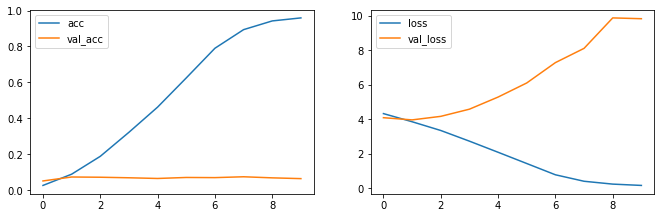

In [ ]:
# Visualizamos la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

plt.show()

11/11 [==============================] - 5s 464ms/step


<Axes: >

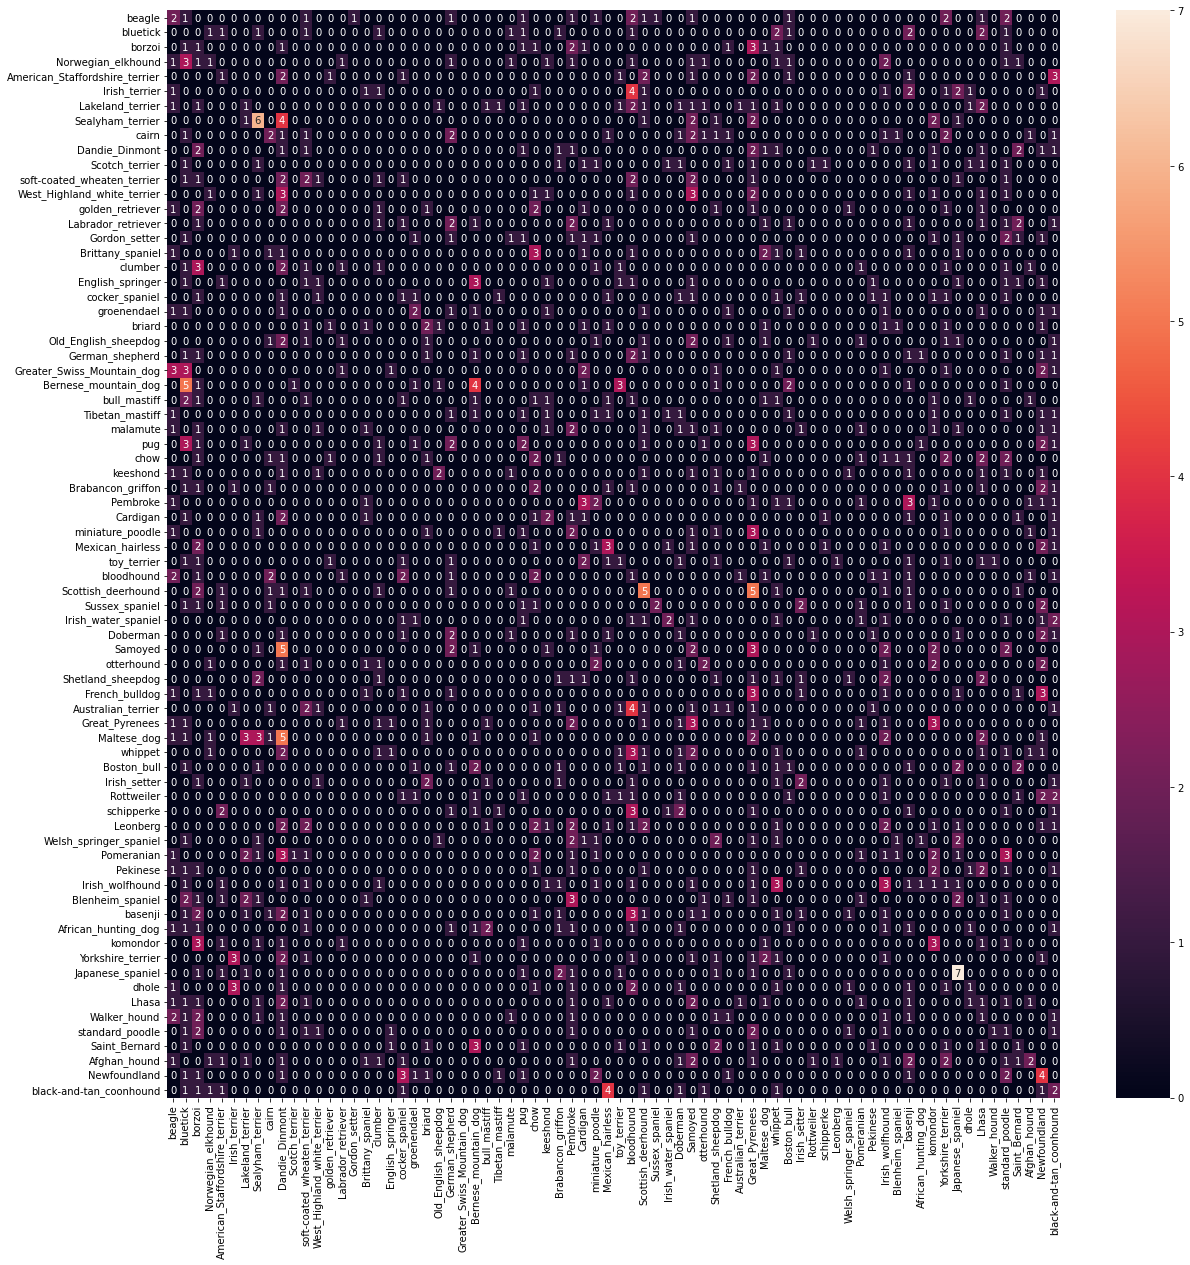

In [ ]:
# Visualizamos la matriz de confusion
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true= y_test
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)

df_cm=pd.DataFrame(confusion_matrix, index = [i for  i in classes], columns = [i for i in classes])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

Obtén las gráficas de evaluación y la matriz de confusión y  extrae conclusiones de estos resultados

---

`Después de 10 épocas de entrenamiento, la precisión de entrenamiento del modelo es alta pero la precisión de validación sigue siendo muy baja, lo que indica que el modelo puede no ser lo suficientemente complejo o que necesita más datos de entrenamiento. Los valores de pérdida tanto para el conjunto de entrenamiento como para el de validación también son muy altos, poniendo de manifiesto que el modelo aún no puede minimizar adecuadamente el error de la predicción. Sería conveniente experimentar más con la arquitectura y los hiperparámetros del modelo para lograr un mejor rendimiento.`



---


<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section6"></a> 
## <font color="#00586D"> 6. Ajuste de hiperparámetros</font>
<br>




En esta sección vamos a intentar mejorar la red anterior con capas `Dropout` y cambiando los hiperparámetros.

La arquitectura de la red es la siguiente:

* Tamaño de entrada será `(100, 120, 3)`.
* Capa convolucional con 32 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa *Dropout* con valor 0.5.
* Capa convolucional con 64 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa convolucional con 64 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa *Dropout* con valor 0.5.
* Capa *Fully connected* con 1024 neuronas con activación *ReLU*.
* Capa *Dropout* con valor 0.2.
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `sparse_categorical_crossentropy`
* Optimizador: `Adam`
* Learning rate: 0,001
* Epochs: 10
* Tamaño del batch: 128

In [12]:
# Cargamos datos con las funciones de generación de dataset
img_size = (100,120,3)
batch_size = 128

# esta funcion obtiene la base de datos, e incluso podemos pasarle una preprocessing function
train_dataset = get_dataset(x_train, y_train, img_size[:-1], batch_size)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], batch_size)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], batch_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
# COMPLETAR:

#   - Crear la red
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation = 'relu',
                                 input_shape=img_size
                                 )
          )
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=64,
                                 kernel_size=(5,5),
                                 activation = 'relu')
          )
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64,
                                 kernel_size=(5,5),
                                 activation = 'relu')
          )
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(classes), activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 116, 32)       2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 58, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 58, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 54, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 27, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 23, 64)        1

In [15]:
# COMPLETAR:
#   - Entrena la red

# Configuramos entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lanzamos entrenamiento
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
73/73 [==============================] - 1754s 24s/step - loss: 4.2803 - accuracy: 0.0220 - val_loss: 4.2338 - val_accuracy: 0.0306
Epoch 2/10
73/73 [==============================] - 40s 549ms/step - loss: 4.0887 - accuracy: 0.0439 - val_loss: 4.0384 - val_accuracy: 0.0612
Epoch 3/10
73/73 [==============================] - 36s 491ms/step - loss: 3.9441 - accuracy: 0.0705 - val_loss: 3.9919 - val_accuracy: 0.0577
Epoch 4/10
73/73 [==============================] - 40s 552ms/step - loss: 3.8114 - accuracy: 0.0915 - val_loss: 3.8925 - val_accuracy: 0.0810
Epoch 5/10
73/73 [==============================] - 37s 510ms/step - loss: 3.6891 - accuracy: 0.1101 - val_loss: 3.8650 - val_accuracy: 0.0905
Epoch 6/10
73/73 [==============================] - 40s 543ms/step - loss: 3.5644 - accuracy: 0.1305 - val_loss: 3.8945 - val_accuracy: 0.0900
Epoch 7/10
73/73 [==============================] - 36s 498ms/step - loss: 3.4812 - accuracy: 0.1476 - val_loss: 3.9733 - val_accuracy: 0.0819

In [16]:
# COMPLETAR:
#   - Evalúa la red
# Evaluamos con el conjunto de test
model.evaluate(test_dataset)

11/11 [==============================] - 266s 24s/step - loss: 3.8590 - accuracy: 0.0884


[3.8590176105499268, 0.08837209641933441]

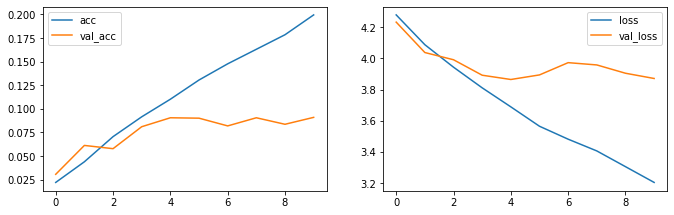

In [17]:
# Visualizamos la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

plt.show()

11/11 [==============================] - 5s 463ms/step


<Axes: >

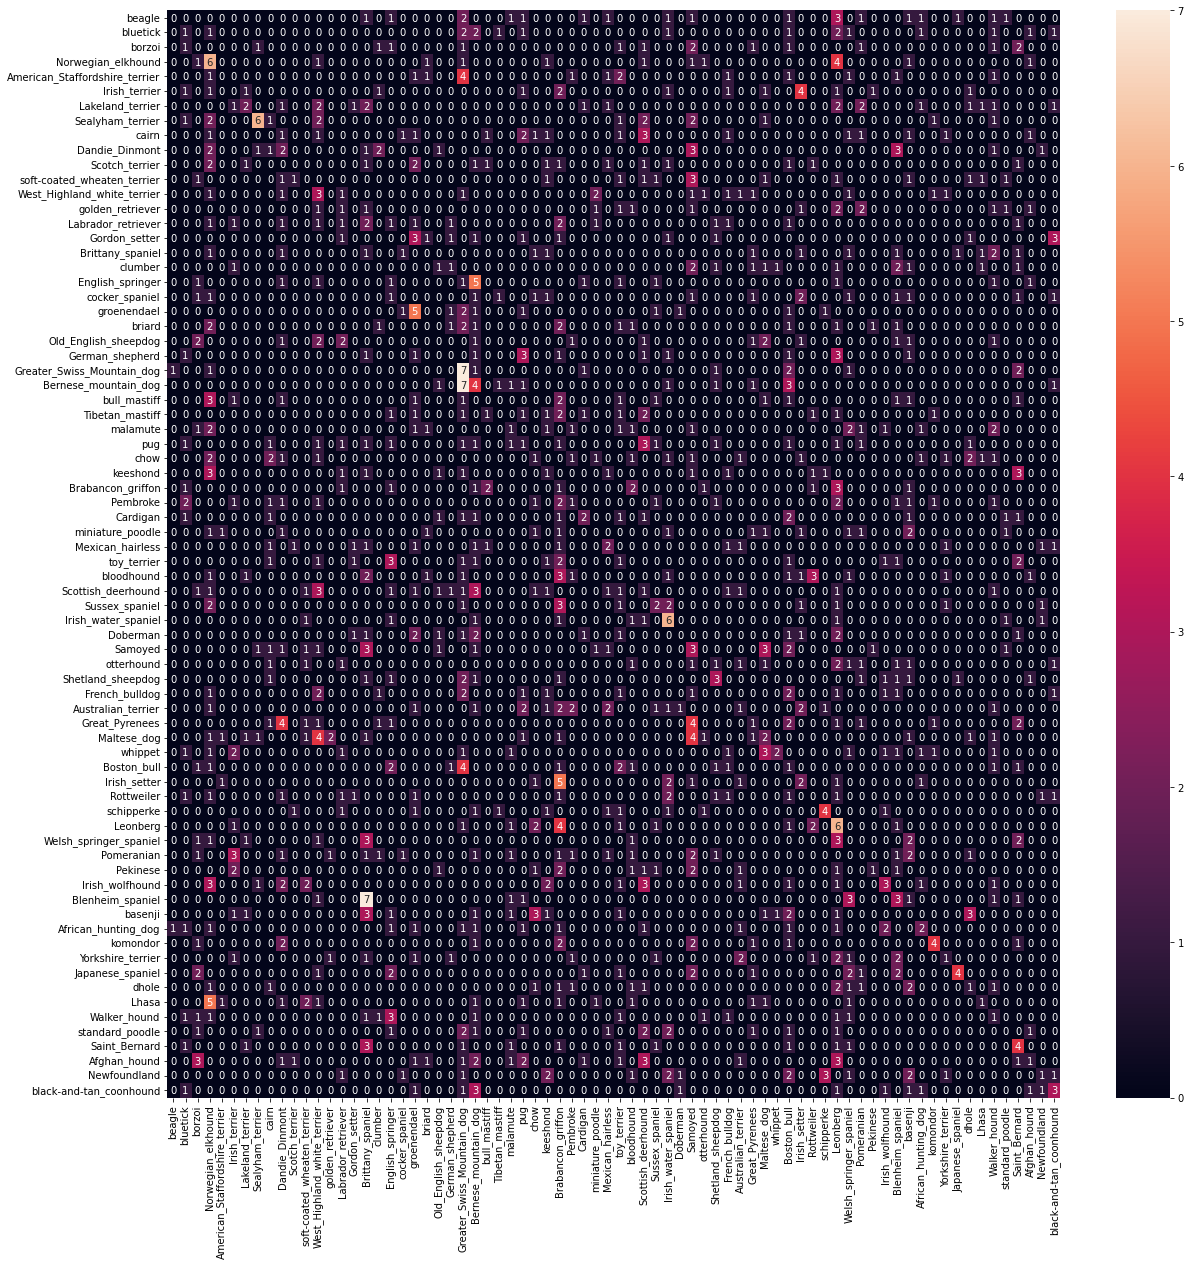

In [18]:
# Visualizamos la matriz de confusion
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true= y_test
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)

df_cm=pd.DataFrame(confusion_matrix, index = [i for  i in classes], columns = [i for i in classes])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

Obtén las gráficas de evaluación y la matriz de confusión y  extrae conclusiones de estos resultados

---

`Los resultados indican que el modelo aún tiene dificultades para aprender las clases de perros. El uso de capas de dropout no es suficiente para resolverlo, y puede ser necesario realizar ajustes adicionales en la arquitectura del modelo, tales como modificar el resto de hiperparametros o probar otras arquitecturas de redes neuronales.`



---


<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section7"></a> 
## <font color="#00586D"> 7. Modelos pre-entrenados (fine-tunning)</font>
<br>




En esta sección tendréis que utilizar los conocimientos sobre los modelos pre-entrenados y _fine-tunning_, donde tendréis que adaptar una red pre-entrenada a nuestro problema. El modelo pre-entreando que tendréis que usar es _Inception_, cuya versión 3 es de las más utilizadas en _Fine-tuning_ por sus buenos resultados.

### <font color="#00586D"> Inception</font>


La configuración de la red a cargar es la siguiente:

* Tamaño de entrada será `(299, 299, 3)`.
* Elegiremos la configuración `include_top = false` y el `pooling = 'avg'`
* Añadiremos una capa de _Dropout_ de 0.5
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `sparse_categorical_crossentropy`
* Optimizador: `Adam`
* Epochs: 10
* Tamaño del batch: 128

In [21]:
# Cargamos datos con las funciones de generación de dataset
# esta vez usams la fucnion de preprocesamiento de inception

# Cargamos datos con las funciones de generación de dataset
img_size = (299,299,3)
batch_size = 128

# esta funcion obtiene la base de datos, e incluso podemos pasarle una preprocessing function
train_dataset = get_dataset(x_train, y_train, img_size[:-1], batch_size, prep_func=tf.keras.applications.mobilenet.preprocess_input)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], batch_size, prep_func=tf.keras.applications.mobilenet.preprocess_input)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], batch_size, prep_func=tf.keras.applications.mobilenet.preprocess_input)


In [22]:
# COMPLETAR:
#   - Crear la red
from keras.applications.inception_v3 import InceptionV3

# cargamos el modelo base
base_model = InceptionV3(input_shape=img_size, include_top=False, pooling='avg')

# y congelamos el entrenamiento en todas las capas
for layer in base_model.layers:
    layer.trainable = False

# version con Model
x = tf.keras.layers.Dropout(0.5)(base_model.output)
x = tf.keras.layers.Dense(len(classes), activation='softmax')(x)
model = tf.keras.Model(inputs = base_model.input, outputs=x)

model.summary()

87910968/87910968 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d_3[0][0]']               
 alization)                  

In [23]:
# COMPLETAR:
#   - Entrena la red
# Configuramos entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lanzamos entrenamiento
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
73/73 [==============================] - 79s 906ms/step - loss: 1.5524 - accuracy: 0.7327 - val_loss: 0.3143 - val_accuracy: 0.9457
Epoch 2/10
73/73 [==============================] - 61s 835ms/step - loss: 0.2651 - accuracy: 0.9473 - val_loss: 0.2062 - val_accuracy: 0.9483
Epoch 3/10
73/73 [==============================] - 62s 849ms/step - loss: 0.1852 - accuracy: 0.9547 - val_loss: 0.1745 - val_accuracy: 0.9492
Epoch 4/10
73/73 [==============================] - 63s 868ms/step - loss: 0.1530 - accuracy: 0.9634 - val_loss: 0.1640 - val_accuracy: 0.9526
Epoch 5/10
73/73 [==============================] - 52s 702ms/step - loss: 0.1288 - accuracy: 0.9659 - val_loss: 0.1594 - val_accuracy: 0.9530
Epoch 6/10
73/73 [==============================] - 58s 787ms/step - loss: 0.1141 - accuracy: 0.9699 - val_loss: 0.1536 - val_accuracy: 0.9548
Epoch 7/10
73/73 [==============================] - 55s 750ms/step - loss: 0.1023 - accuracy: 0.9720 - val_loss: 0.1511 - val_accuracy: 0.9569

In [24]:
# COMPLETAR:
#   - Evalúa la red

# Evaluamos con el conjunto de test
model.evaluate(test_dataset)

11/11 [==============================] - 7s 610ms/step - loss: 0.1569 - accuracy: 0.9543


[0.15693910419940948, 0.9542635679244995]

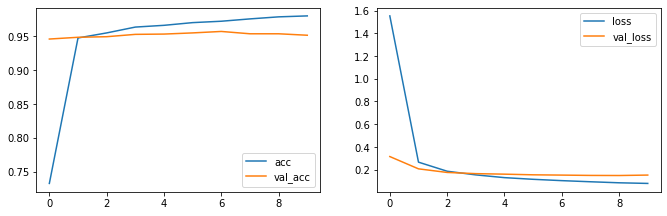

In [25]:
# Visualizamos la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

plt.show()

11/11 [==============================] - 9s 733ms/step


<Axes: >

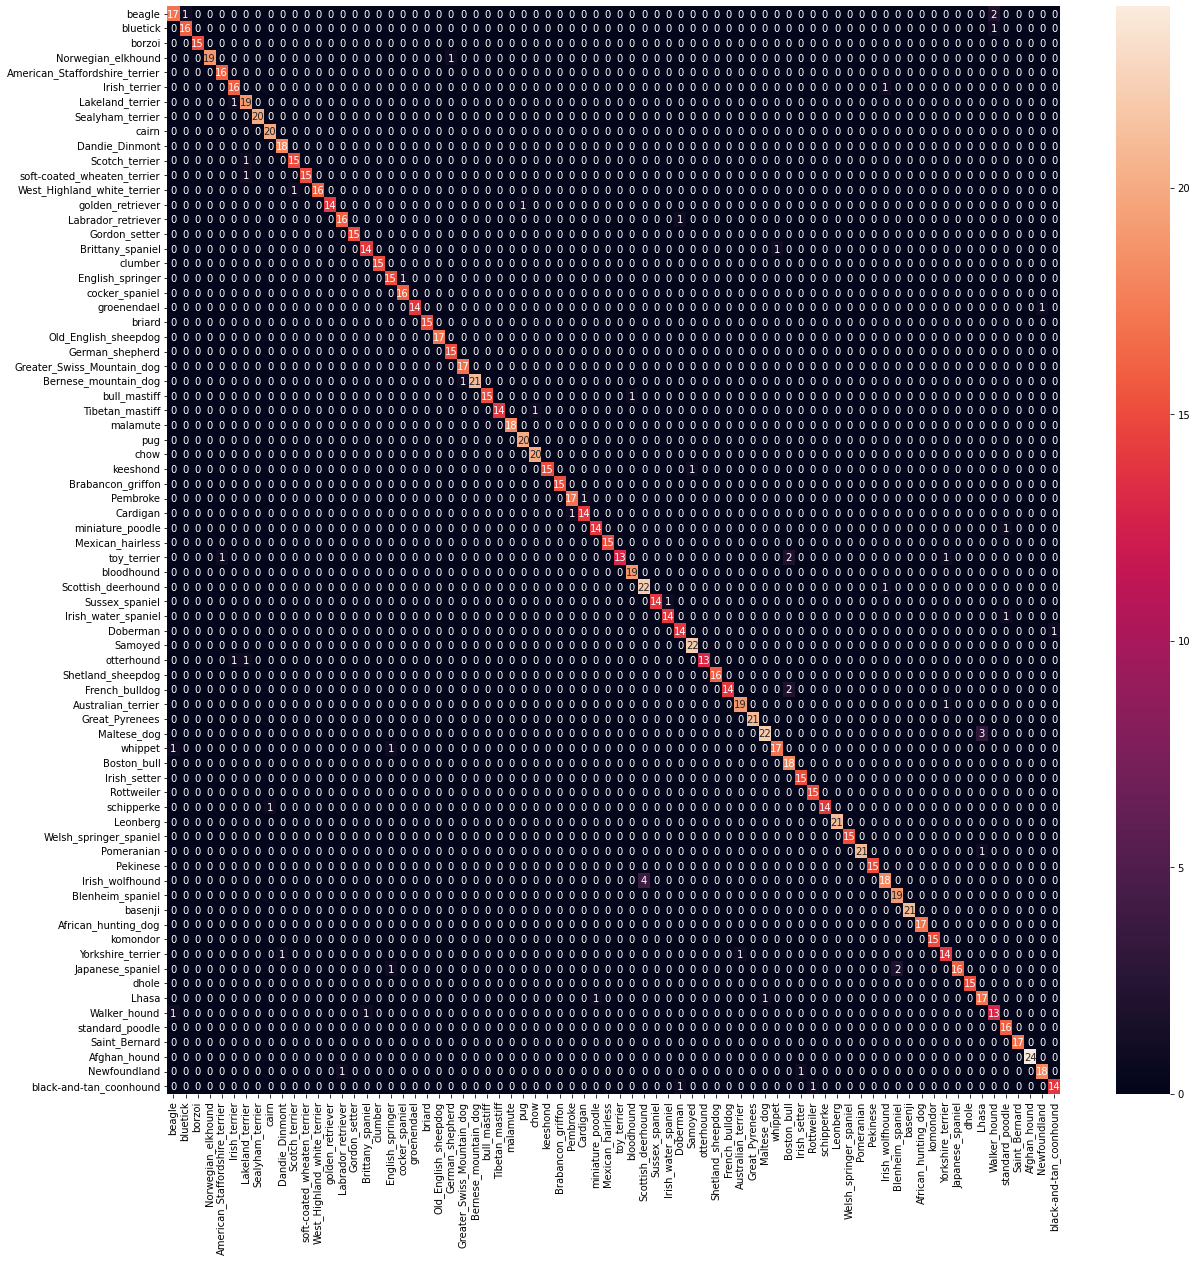

In [26]:
# Visualizamos la matriz de confusion
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true= y_test
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)

df_cm=pd.DataFrame(confusion_matrix, index = [i for  i in classes], columns = [i for i in classes])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

Obtén las gráficas de evaluación y la matriz de confusión y  extrae conclusiones de estos resultados

---

`El uso de fine-tuning del modelo Inception v3 permite mejorar los valores de precision en el entrenamiento y en la validación. Se obtienen valores por encima del 95 %. Ademas como se puede observar en la matriz de confusión todos las clases se encuentran practicamente en la diagonal indicando que existe practicamente total correspondencia entre las razas predichas y las reales`



---


<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section8"></a> 
## <font color="#00586D"> 8. Data augmentation</font>
<br>





En este apartado se deberán aplicar algunas de las funciones de preprocesamiento vistas en la clase de _data augmentation_. Nos centraremos en *data augmentation* estocástico sobre la red obtenida en el apartado de modelos desde 0 y tratar de mejorar el rendimiento. Vamos a utilizar una o varias de las siguientes modificaciones:

  *    Flip horizontal
  *    Flip vertical
  *    Contraste

La arquitectura de la red debe ser siguiente:
* Tamaño de entrada será `(100, 120, 3)`.
* Capa convolucional con 32 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa convolucional con 64 kernels de tamaño 5x5 con activación *ReLU*.
* Capa *Max Pooling* con reducción de 2.
* Capa *Fully connected* con 1024 neuronas con activación *ReLU*.
* Capa de salida con *softmax*.

Configuración del entrenamiento:
* Función de perdida: `sparse_categorical_crossentropy`
* Optimizador: `Adam`
* Learning rate: 0,001
* Epochs: 10
* Tamaño del batch: 128

In [27]:
# Cargamos datos con las funciones de generación de dataset
img_size = (100,120,3)
batch_size = 128

# esta funcion obtiene la base de datos, e incluso podemos pasarle una preprocessing function
train_dataset = get_dataset(x_train, y_train, img_size[:-1], batch_size)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], batch_size)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], batch_size)


In [36]:
# COMPLETAR:
#   - Crear la red
model = tf.keras.Sequential()
model.add(tf.keras.layers.RandomFlip('vertical'))
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation = 'relu',
                                 input_shape=img_size
                                 )
          )
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64,
                                 kernel_size=(5,5),
                                 activation = 'relu')
          )
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dense(len(classes), activation="softmax"))

In [37]:
# COMPLETAR:
#   - Entrena la red
# Configuramos entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lanzamos entrenamiento
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
73/73 [==============================] - 45s 566ms/step - loss: 4.2803 - accuracy: 0.0330 - val_loss: 3.9876 - val_accuracy: 0.0664
Epoch 2/10
73/73 [==============================] - 39s 531ms/step - loss: 3.7051 - accuracy: 0.1140 - val_loss: 3.9625 - val_accuracy: 0.0853
Epoch 3/10
73/73 [==============================] - 65s 876ms/step - loss: 3.0336 - accuracy: 0.2554 - val_loss: 4.5633 - val_accuracy: 0.0668
Epoch 4/10
73/73 [==============================] - 42s 582ms/step - loss: 2.2778 - accuracy: 0.4273 - val_loss: 4.8964 - val_accuracy: 0.0754
Epoch 5/10
73/73 [==============================] - 40s 544ms/step - loss: 1.6014 - accuracy: 0.5855 - val_loss: 5.9424 - val_accuracy: 0.0784
Epoch 6/10
73/73 [==============================] - 45s 613ms/step - loss: 1.0559 - accuracy: 0.7266 - val_loss: 6.9006 - val_accuracy: 0.0741
Epoch 7/10
73/73 [==============================] - 40s 544ms/step - loss: 0.6728 - accuracy: 0.8231 - val_loss: 8.1626 - val_accuracy: 0.0702

In [38]:
# COMPLETAR:
#   - Crear la red
model = tf.keras.Sequential()
model.add(tf.keras.layers.RandomFlip('horizontal'))
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation = 'relu',
                                 input_shape=img_size
                                 )
          )
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64,
                                 kernel_size=(5,5),
                                 activation = 'relu')
          )
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dense(len(classes), activation="softmax"))

In [39]:
# COMPLETAR:
#   - Entrena la red
# Configuramos entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lanzamos entrenamiento
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
73/73 [==============================] - 44s 570ms/step - loss: 4.3112 - accuracy: 0.0327 - val_loss: 4.0017 - val_accuracy: 0.0638
Epoch 2/10
73/73 [==============================] - 43s 588ms/step - loss: 3.6622 - accuracy: 0.1221 - val_loss: 4.0390 - val_accuracy: 0.0797
Epoch 3/10
73/73 [==============================] - 44s 608ms/step - loss: 2.9721 - accuracy: 0.2739 - val_loss: 4.5662 - val_accuracy: 0.0832
Epoch 4/10
73/73 [==============================] - 40s 542ms/step - loss: 2.1714 - accuracy: 0.4516 - val_loss: 5.8987 - val_accuracy: 0.0539
Epoch 5/10
73/73 [==============================] - 40s 544ms/step - loss: 1.4349 - accuracy: 0.6233 - val_loss: 7.3776 - val_accuracy: 0.0595
Epoch 6/10
73/73 [==============================] - 42s 575ms/step - loss: 0.7929 - accuracy: 0.7963 - val_loss: 7.4810 - val_accuracy: 0.0707
Epoch 7/10
73/73 [==============================] - 44s 604ms/step - loss: 0.4383 - accuracy: 0.8876 - val_loss: 8.7222 - val_accuracy: 0.0698

In [40]:
# COMPLETAR:
#   - Crear la red
model = tf.keras.Sequential()
model.add(tf.keras.layers.RandomContrast(0.2))
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation = 'relu',
                                 input_shape=img_size
                                 )
          )
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64,
                                 kernel_size=(5,5),
                                 activation = 'relu')
          )
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dense(len(classes), activation="softmax"))

In [41]:
# COMPLETAR:
#   - Entrena la red
# Configuramos entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lanzamos entrenamiento
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10


73/73 [==============================] - 112s 1s/step - loss: 4.2852 - accuracy: 0.0278 - val_loss: 4.0907 - val_accuracy: 0.0470
Epoch 2/10
73/73 [==============================] - 110s 1s/step - loss: 3.8695 - accuracy: 0.0905 - val_loss: 4.0797 - val_accuracy: 0.0590
Epoch 3/10
73/73 [==============================] - 114s 2s/step - loss: 3.2986 - accuracy: 0.2059 - val_loss: 4.7419 - val_accuracy: 0.0560
Epoch 4/10
73/73 [==============================] - 107s 1s/step - loss: 2.6681 - accuracy: 0.3495 - val_loss: 4.9110 - val_accuracy: 0.0651
Epoch 5/10
73/73 [==============================] - 128s 2s/step - loss: 1.9014 - accuracy: 0.5273 - val_loss: 6.3945 - val_accuracy: 0.0668
Epoch 6/10
73/73 [==============================] - 118s 2s/step - loss: 1.1900 - accuracy: 0.6949 - val_loss: 7.2406 - val_accuracy: 0.0629
Epoch 7/10
73/73 [==============================] - 139s 2s/step - loss: 0.8247 - accuracy: 0.7891 - val_loss: 8.6928 - val_accuracy: 0.0633
Epoch 8/10
73/73 [======

In [42]:
# COMPLETAR:
#   - Evalúa la red

# Evaluamos con el conjunto de test
model.evaluate(test_dataset)

11/11 [==============================] - 4s 350ms/step - loss: 10.2972 - accuracy: 0.0651


[10.297240257263184, 0.0651162788271904]

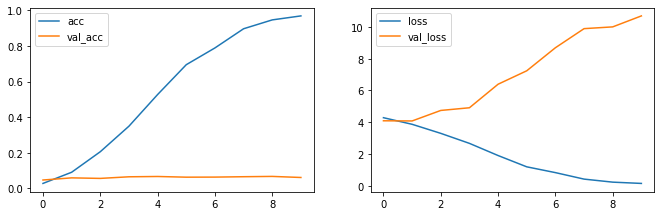

In [43]:
# Visualizamos la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

plt.show()

11/11 [==============================] - 5s 501ms/step


<Axes: >

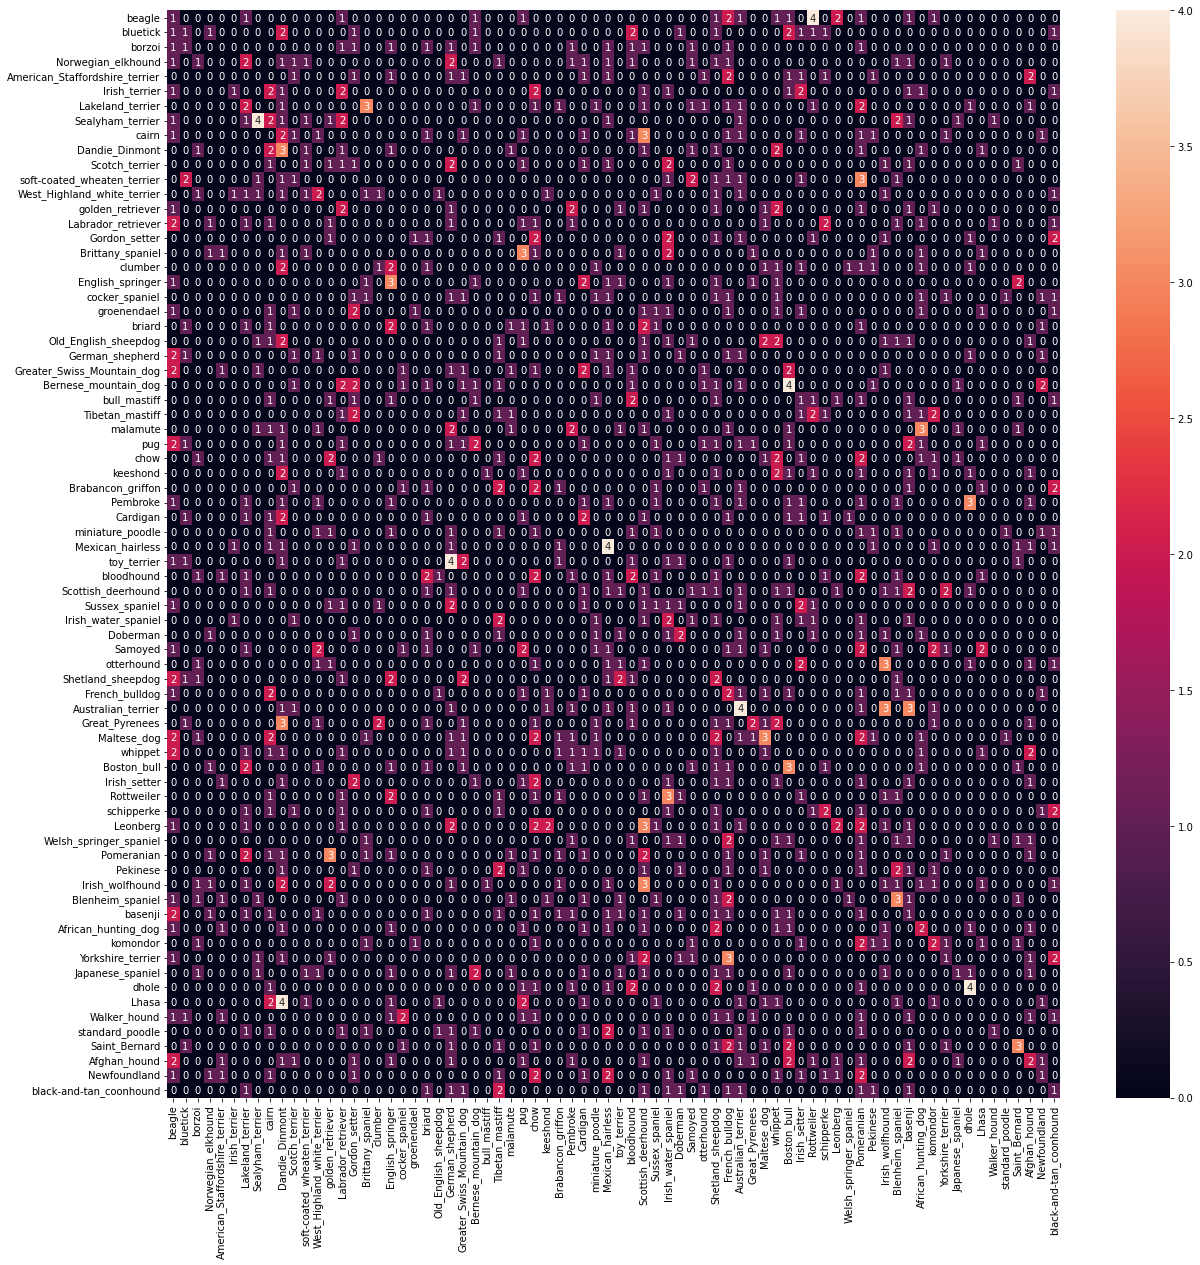

In [44]:
# Visualizamos la matriz de confusion
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true= y_test
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)

df_cm=pd.DataFrame(confusion_matrix, index = [i for  i in classes], columns = [i for i in classes])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

Obtén las gráficas de evaluación y la matriz de confusión y  extrae conclusiones de estos resultados

---

`El uso de data augmentation no implica una mejora de la precisión de validacion del modelo para las 3 opciones estudiadas obteniendo valores similares a cuando no se empleaban, es decir, alto valor de precisión de entrenamiento y bajo de validación, lo que implica sobreajuste del modelo`



---


<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section9"></a> 
## <font color="#00586D"> AutoKeras (opcional) </font>
<br>


En este experimentos vamos a utilizar AutoKeras para realizar el entrenamiento. Nos centraremos en utilizar el bloque `ImageClassifier` a alto nivel, con tan solo un `max_trials` de 1 ya que será un experimento muy costoso computacionalmente.

La arquitectura de la red debe ser siguiente:
* Tamaño de entrada será `(100, 120, 3)`.
* Bloque `ImageClassifier` con la siguiente configuración:
  - `max_trials` de 1
  - En `metrics` incluye el `accuracy`
  - `overwrite` a `True`

  En este tipo de bloque puedes pasarle al parámetro `x` un `tf.data.Dataset` al igual que al parámetros `validation_data`.

Configuración del entrenamiento:
* Epochs: 10
* Callbacks: usa `EarlyStopping` con un `patience` de 2 para terminar antes el entrenamiento si el modelo deja de aprender.

In [ ]:
!pip install autokeras

In [ ]:
import autokeras as ak

In [45]:
# Cargamos datos con las funciones de generación de dataset
img_size = (100,120,3)
batch_size = 128

# esta funcion obtiene la base de datos, e incluso podemos pasarle una preprocessing function
train_dataset = get_dataset(x_train, y_train, img_size[:-1], batch_size)
valid_dataset = get_dataset(x_valid, y_valid, img_size[:-1], batch_size)
test_dataset = get_dataset(x_test, y_test, img_size[:-1], batch_size)

In [46]:
# COMPLETAR:
#   - Crear la red
# Initialize the image classifier.
clf = ak.ImageClassifier(
    max_trials=1,
    metrics=['accuracy'],
    overwrite=True
)

In [47]:
# COMPLETAR:
#   - Entrena la red
# Feed the image classifier with training data.
history = clf.fit(train_dataset, 
        epochs=10, 
        validation_data=valid_dataset, 
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


Trial 1 Complete [00h 12m 35s]
val_loss: 4.023684501647949

Best val_loss So Far: 4.023684501647949
Total elapsed time: 00h 12m 35s


In [48]:
# COMPLETAR:
#   - Evalúa la red

# Evaluamos con el conjunto de test
clf.evaluate(test_dataset)

11/11 [==============================] - 17s 1s/step - loss: 3.9740 - accuracy: 0.0953


[3.973999261856079, 0.09534883499145508]

11/11 [==============================] - 4s 347ms/step


<Axes: >

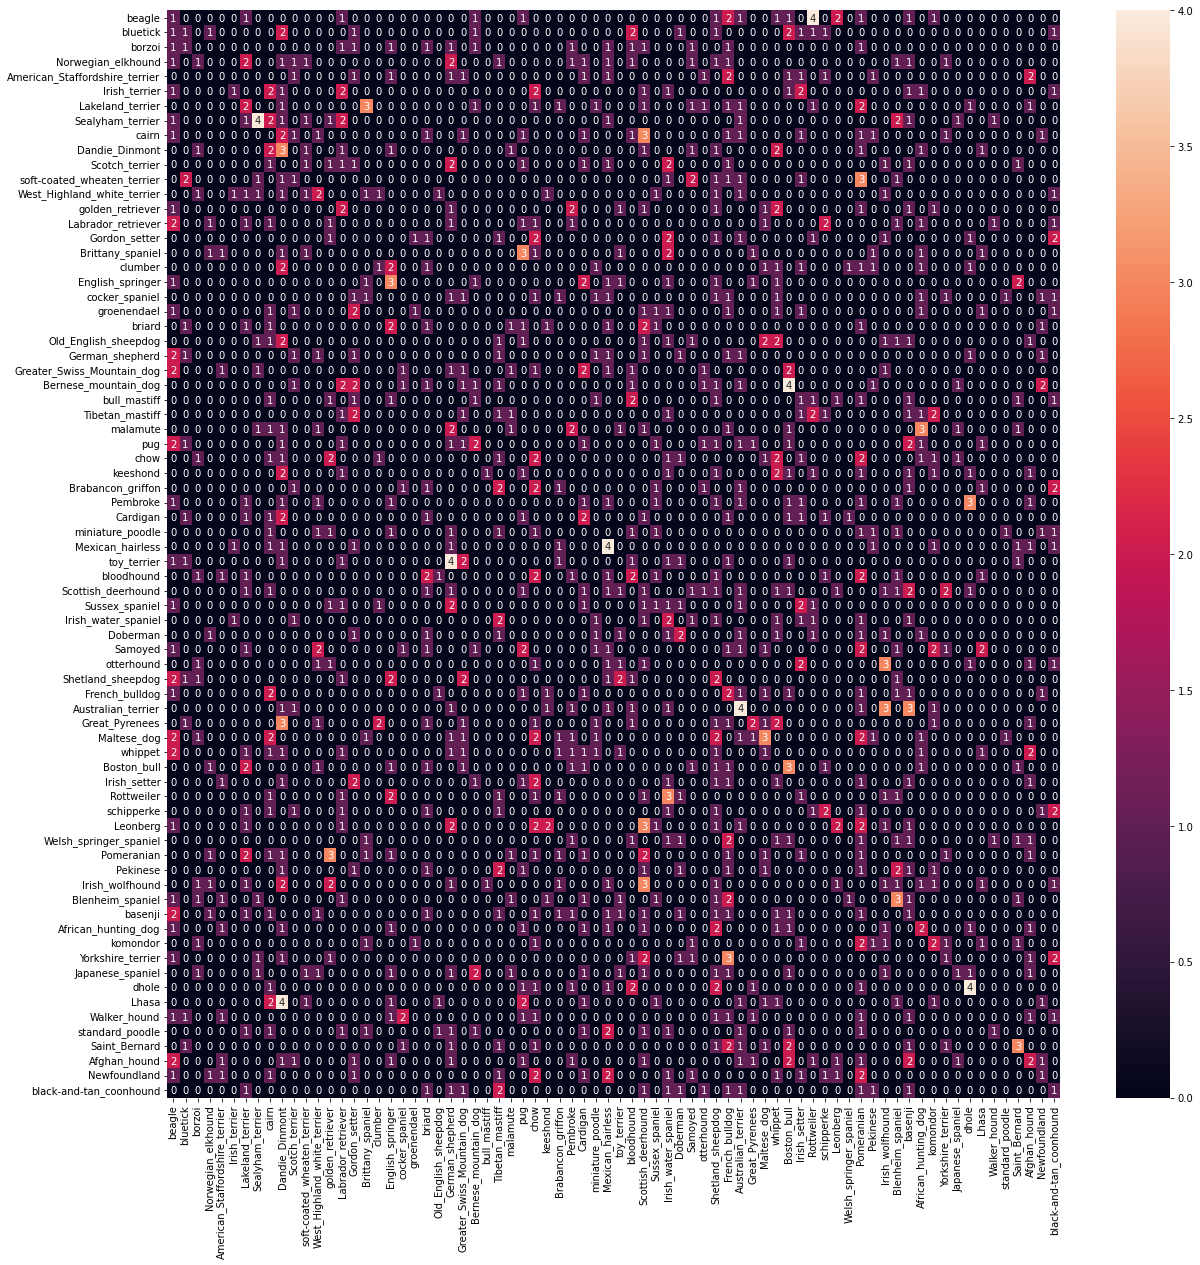

In [50]:
# Visualizamos la matriz de confusion
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true= y_test
confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)

df_cm=pd.DataFrame(confusion_matrix, index = [i for  i in classes], columns = [i for i in classes])
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

Obtén las gráficas de evaluación y la matriz de confusión y  extrae conclusiones de estos resultados

---

`El modelo seleccionado por Autokeras no presenta un rendimiento superior al resto de modelos estudiados en el Notebook`



---


<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="sectionopt"></a> 
## <font color="#00586D"> Conclusión</font>
<br>


Una vez realizado todos los experimentos anteriores, ¿qué modelo elegirías para desplegar en producción? ¿Por qué? 

Explica en breves palabras qué modelo eligirías para desplegar en producción y porqué. Compara cada experimento y extráe tus propias conclusiones.

---

`Si tuviera que elegir un modelo para desplegar en producción, elegiría el modelo basado en fine-tuning de Inception v3. Este modelo obtuvo los mejores resultados en términos de precisión en ambos conjuntos de datos, entrenamiento y validación, con valores superiores al 95%. Además, la matriz de confusión muestra una alta correspondencia entre las razas predichas y las reales, lo que indica que el modelo tiene un buen rendimiento en la clasificación de las diferentes razas de perros.`



---


<div style="text-align: center; font-size: 24px;">
    <img src="https://drive.google.com/uc?id=1xHx0M9NUXi4YcDyi1BwuUE6y0TK0kHfs">
</div>

####  ¡Si has llegado hasta aquí deberías estar super orgullos@!  Ya puedes relajar tus neuronas, les has dado mucho trabajo



<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<div align="right">
<a href="#indice"><font size=6 color="#00586D"><i class="fa fa-coffee" aria-hidden="true"></i></font></a>
</div>